In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


Este proyecto se centra en la predicción de la **rotación de empleados** (abandono) utilizando un conjunto de datos ficticio de recursos humanos. El objetivo es identificar a los empleados con mayor riesgo de dejar la empresa, lo que permite a la gerencia intervenir de manera proactiva con estrategias de retención.

Para lograrlo, se ha seguido un proceso de ciencia de datos que incluye:

**Análisis Exploratorio de Datos (EDA)** para entender las características de los datos y las variables clave que influyen en la rotación.

**Preprocesamiento y balanceo de datos**, donde se ha utilizado SMOTE para manejar el desbalance de clases de la variable objetivo.

**Entrenamiento y evaluación** de múltiples modelos de Machine Learning como Regresión Logística, Árboles de Decisión y Random Forest.

Los resultados demuestran que el modelo de Random Forest es el que mejor se desempeña en la identificación de empleados con riesgo de abandono. Las conclusiones del análisis ofrecen recomendaciones específicas para la gestión de recursos humanos, como la revisión de escalas salariales y la implementación de programas de satisfacción laboral, que buscan reducir la rotación a largo plazo.



**Carga de el dataset**

In [2]:
df=pd.read_csv('/content/HR_Analytics.csv')
print(df.head())
print(df.info())
print(df.describe())

   EmpID  Age AgeGroup Attrition     BusinessTravel  DailyRate  \
0  RM297   18    18-25       Yes      Travel_Rarely        230   
1  RM302   18    18-25        No      Travel_Rarely        812   
2  RM458   18    18-25       Yes  Travel_Frequently       1306   
3  RM728   18    18-25        No         Non-Travel        287   
4  RM829   18    18-25       Yes         Non-Travel        247   

               Department  DistanceFromHome  Education EducationField  ...  \
0  Research & Development                 3          3  Life Sciences  ...   
1                   Sales                10          3        Medical  ...   
2                   Sales                 5          3      Marketing  ...   
3  Research & Development                 5          2  Life Sciences  ...   
4  Research & Development                 8          1        Medical  ...   

   RelationshipSatisfaction  StandardHours  StockOptionLevel  \
0                         3             80                 0   
1     

**definimos la variable attrition o abandono**


--- Distribución de la variable objetivo (Attrition) ---
Attrition
No     1242
Yes     238
Name: count, dtype: int64
Attrition
No     83.918919
Yes    16.081081
Name: proportion, dtype: float64


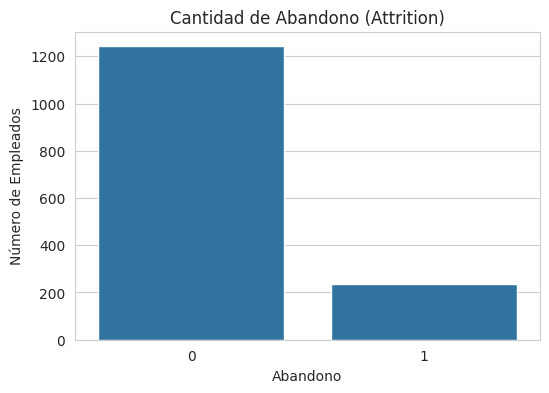

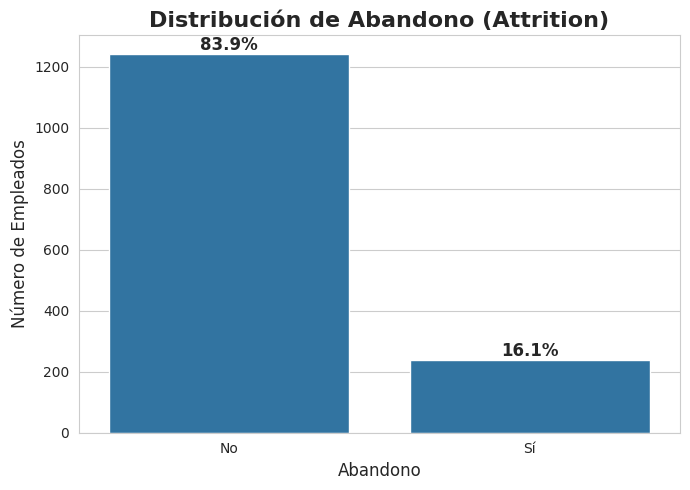

In [3]:

print("\n--- Distribución de la variable objetivo (Attrition) ---")
print(df['Attrition'].value_counts())
print(df['Attrition'].value_counts(normalize=True) * 100)
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
plt.figure(figsize=(6, 4))
sns.countplot(x='Attrition', data=df)
plt.title('Cantidad de Abandono (Attrition)')
plt.xlabel('Abandono')
plt.ylabel('Número de Empleados')
plt.show()


plt.figure(figsize=(7, 5))
ax = sns.countplot(x='Attrition', data=df)
plt.title('Distribución de Abandono (Attrition)', fontsize=16, weight='bold')
plt.xlabel('Abandono', fontsize=12)
plt.ylabel('Número de Empleados', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
total = len(df['Attrition'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


## 2. Análisis Exploratorio de Datos (EDA)
En esta sección, analizaremos la relación entre las características de los empleados y la rotación de personal, buscando patrones que nos ayuden a entender las causas del abandono.

**muestreo de las categorias de las columnas **

In [4]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Attrition' in categorical_cols:
    categorical_cols.remove('Attrition')
elif 'Attrition' in numerical_cols:
    numerical_cols.remove('Attrition')
print(f"Columnas Categóricas ({len(categorical_cols)}): {categorical_cols}")
print(f"Columnas Numéricas ({len(numerical_cols)}): {numerical_cols}")

Columnas Categóricas (11): ['EmpID', 'AgeGroup', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'SalarySlab', 'Over18', 'OverTime']
Columnas Numéricas (26): ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


**muestreo de las variables edad, ingresos mensuales, años totales trabajados, distancia de la casa y años en la compañia**

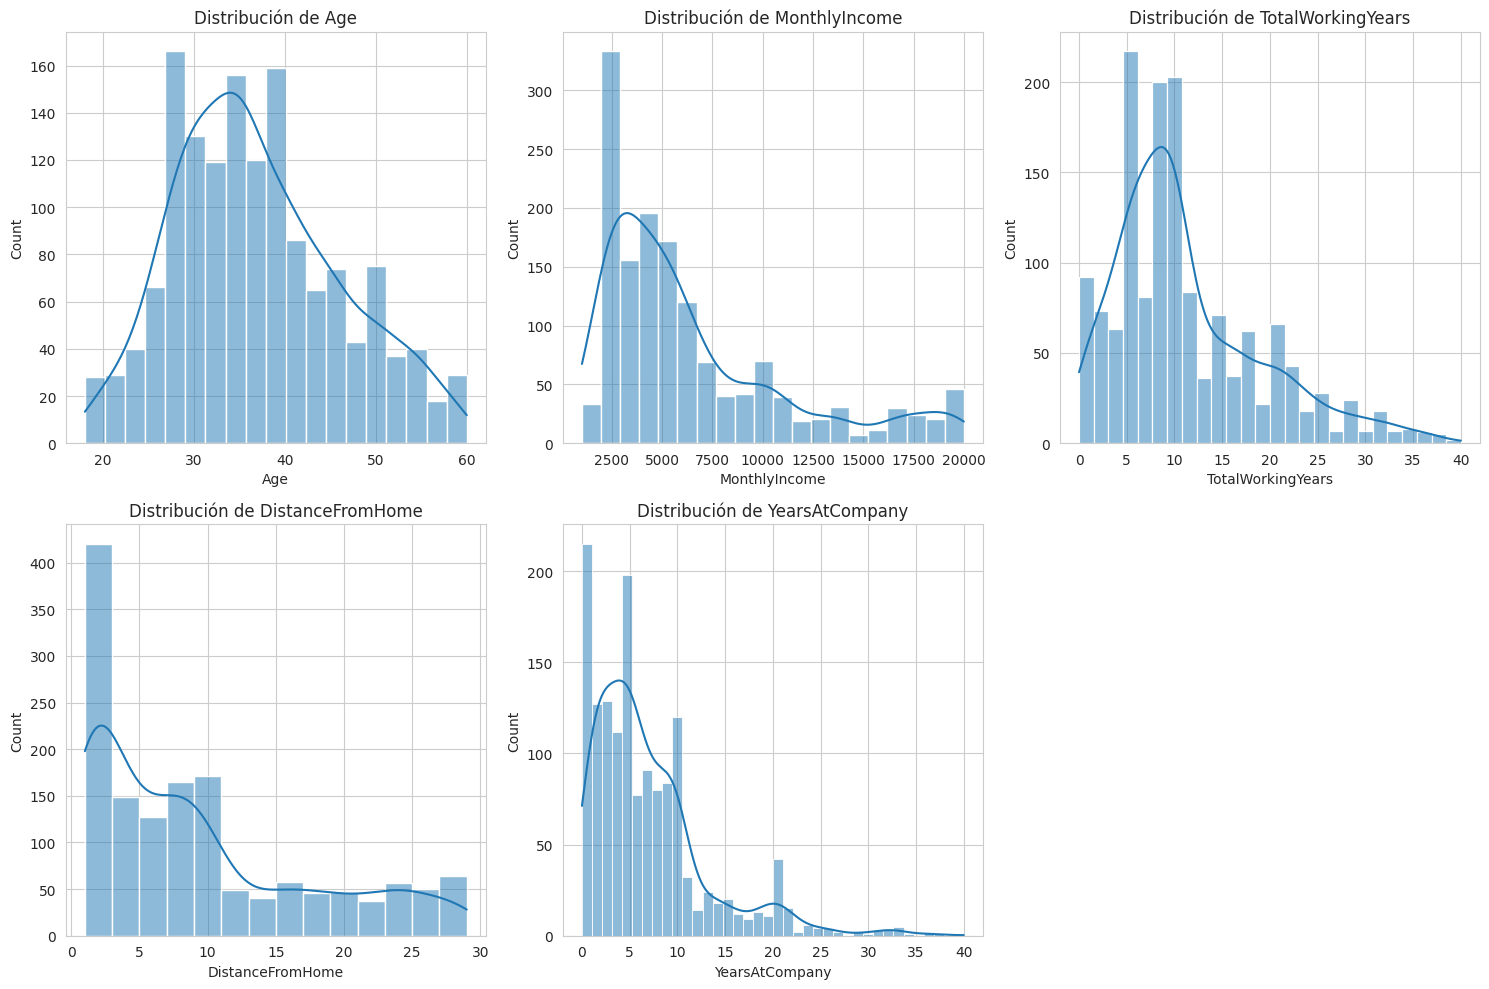

In [5]:
cols_to_plot_num = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'DistanceFromHome', 'YearsAtCompany']
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols_to_plot_num):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

**muestreo de las variables departamentos (en la empresa), rol en el trabajo, campo de la educacion, genero y horas extra**

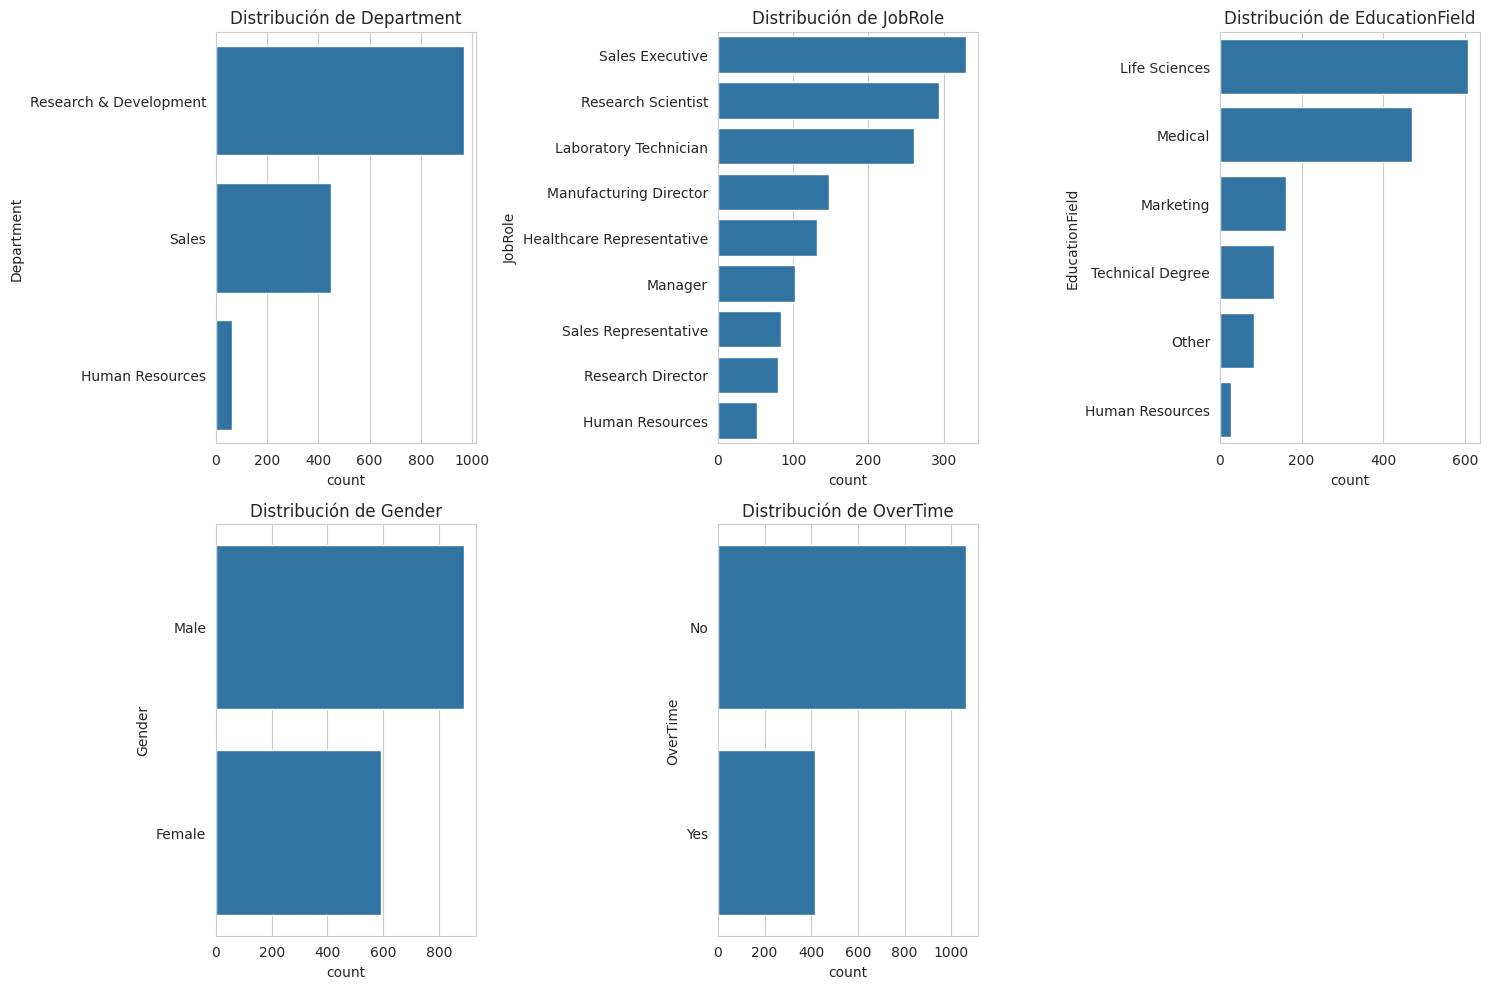

In [6]:
cols_to_plot_cat = ['Department', 'JobRole', 'EducationField', 'Gender', 'OverTime']
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols_to_plot_cat):
    plt.subplot(2, 3, i + 1)
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

**variables vs atrition **

/tmp/ipython-input-45339170.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Attrition', y=col, data=df, palette='viridis')
/tmp/ipython-input-45339170.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Attrition', y=col, data=df, palette='viridis')
/tmp/ipython-input-45339170.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Attrition', y=col, data=df, palette='viridis')
/tmp/ipython-input-45339170.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` var

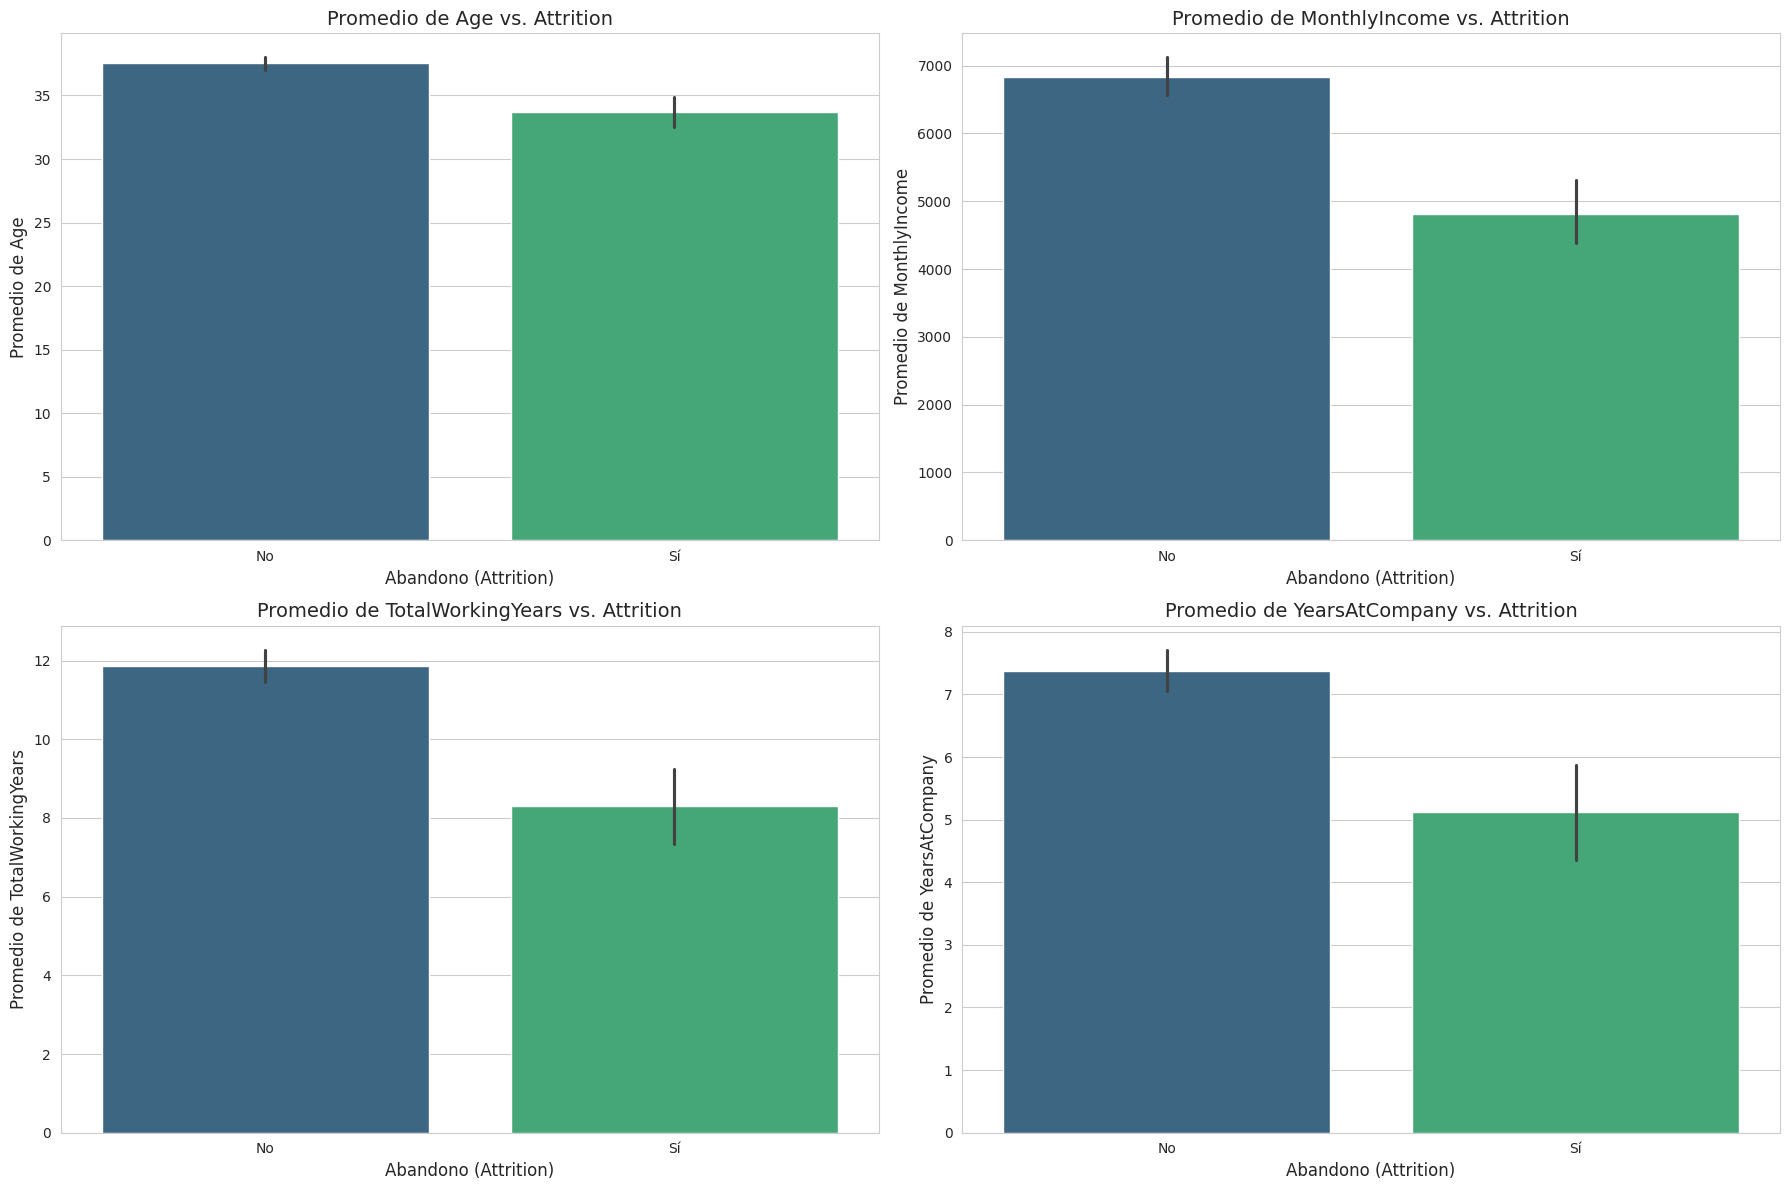

In [7]:

cols_to_plot_num_attrition = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany']
plt.figure(figsize=(18, 12))
for i, col in enumerate(cols_to_plot_num_attrition):
    plt.subplot(2, 2, i + 1)
    sns.barplot(x='Attrition', y=col, data=df, palette='viridis')
    plt.title(f'Promedio de {col} vs. Attrition', fontsize=14)
    plt.xlabel('Abandono (Attrition)', fontsize=12)
    plt.ylabel(f'Promedio de {col}', fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.tight_layout()
plt.show()

El análisis de variables numéricas nos proporciona ideas sobre el perfil de los empleados que abandonan la empresa. Por ejemplo, los gráficos de barras muestran que los empleados que se van tienen un ingreso mensual promedio y un número de años de experiencia laboral inferiores a los que se quedan. Esto sugiere que el abandono está más presente en los empleados más jóvenes o con menos antigüedad en la compañía.

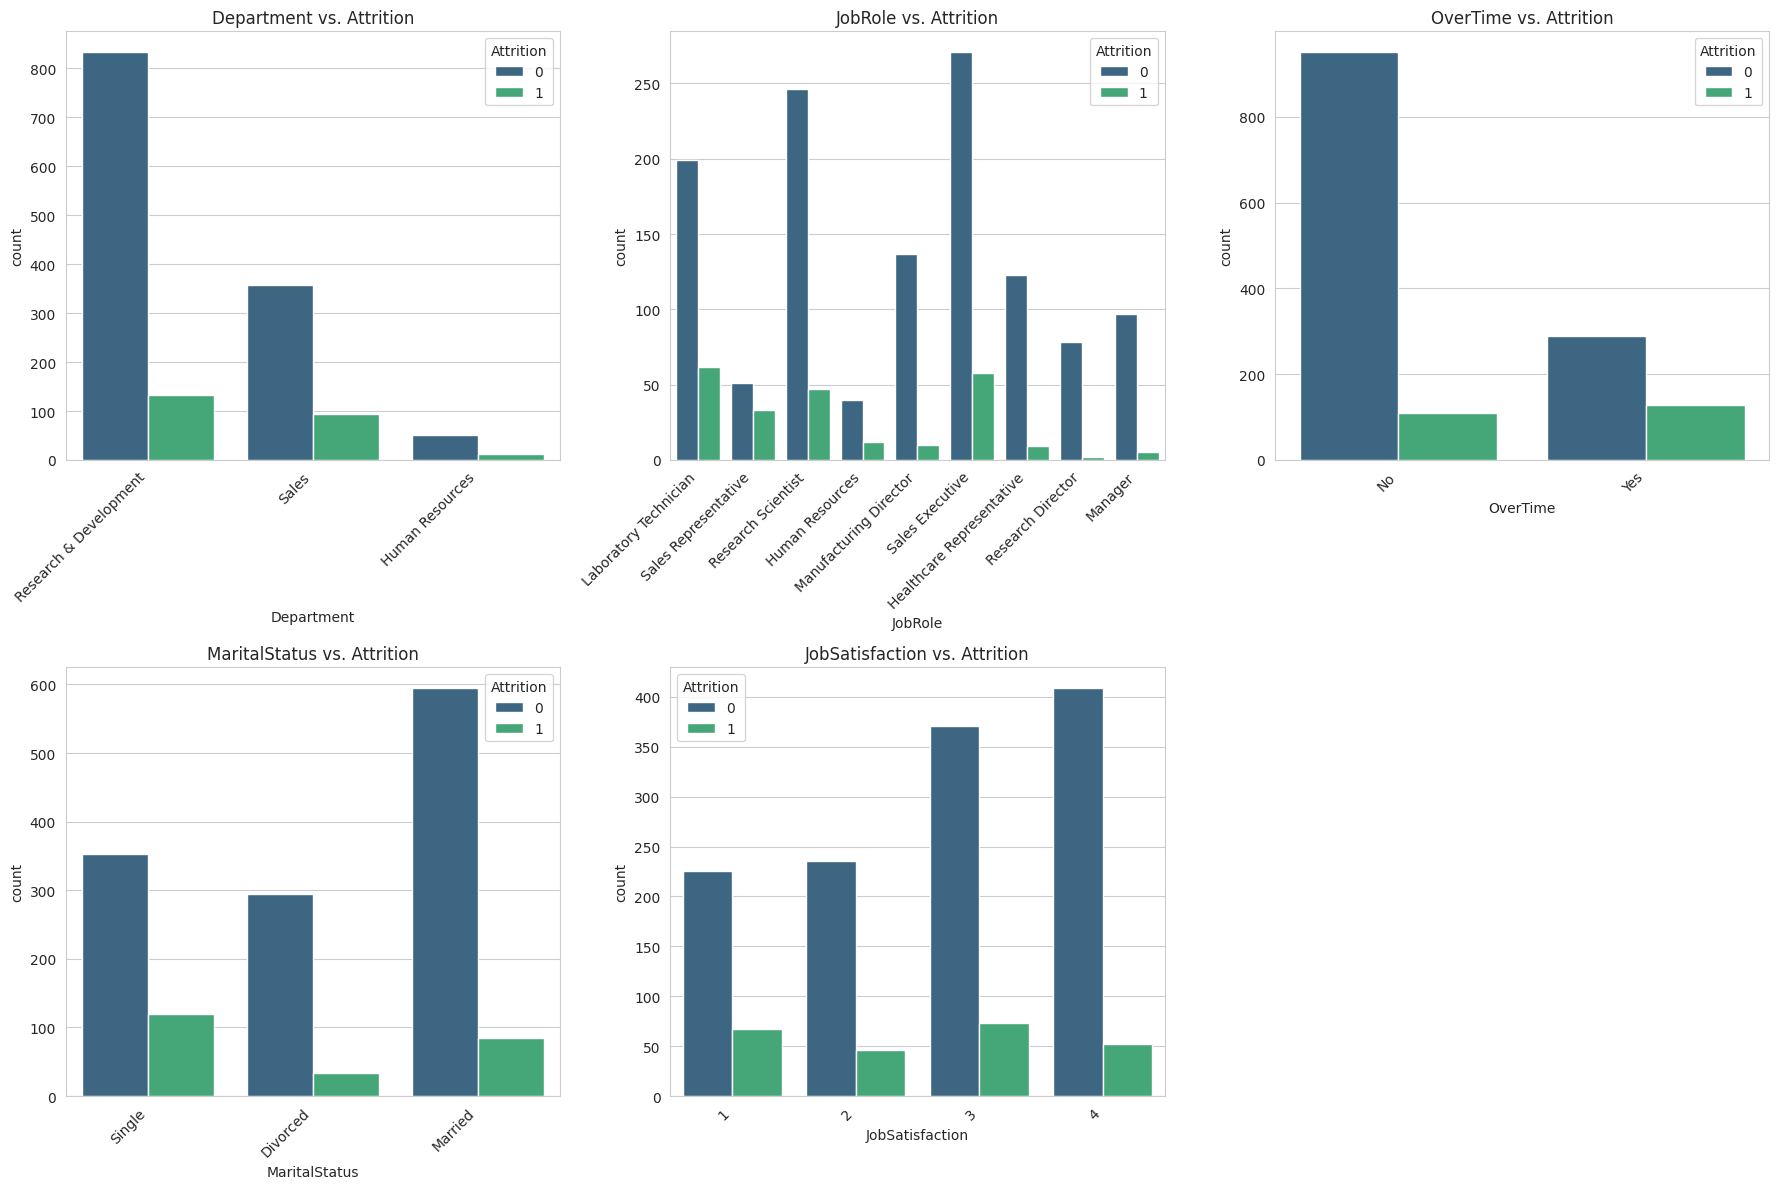

In [8]:

cols_to_plot_cat_attrition = ['Department', 'JobRole', 'OverTime', 'MaritalStatus', 'JobSatisfaction']
plt.figure(figsize=(18, 12))
for i, col in enumerate(cols_to_plot_cat_attrition):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=col, hue='Attrition', data=df, palette='viridis')
    plt.title(f'{col} vs. Attrition')
    plt.xticks(rotation=45, ha='right') # Rotar etiquetas para mejor lectura
plt.tight_layout()
plt.show()

Los gráficos de barras anteriores revelan patrones significativos en la rotación de empleados. Se observa, por ejemplo, que el número de empleados que se van es notablemente más alto en departamentos como Ventas y Recursos Humanos. Además, el gráfico de Horas Extras muestra una correlación muy fuerte: los empleados que trabajan horas extras tienen una tasa de abandono significativamente mayor. Esta información es crucial para dirigir los esfuerzos de retención hacia los grupos de riesgo.

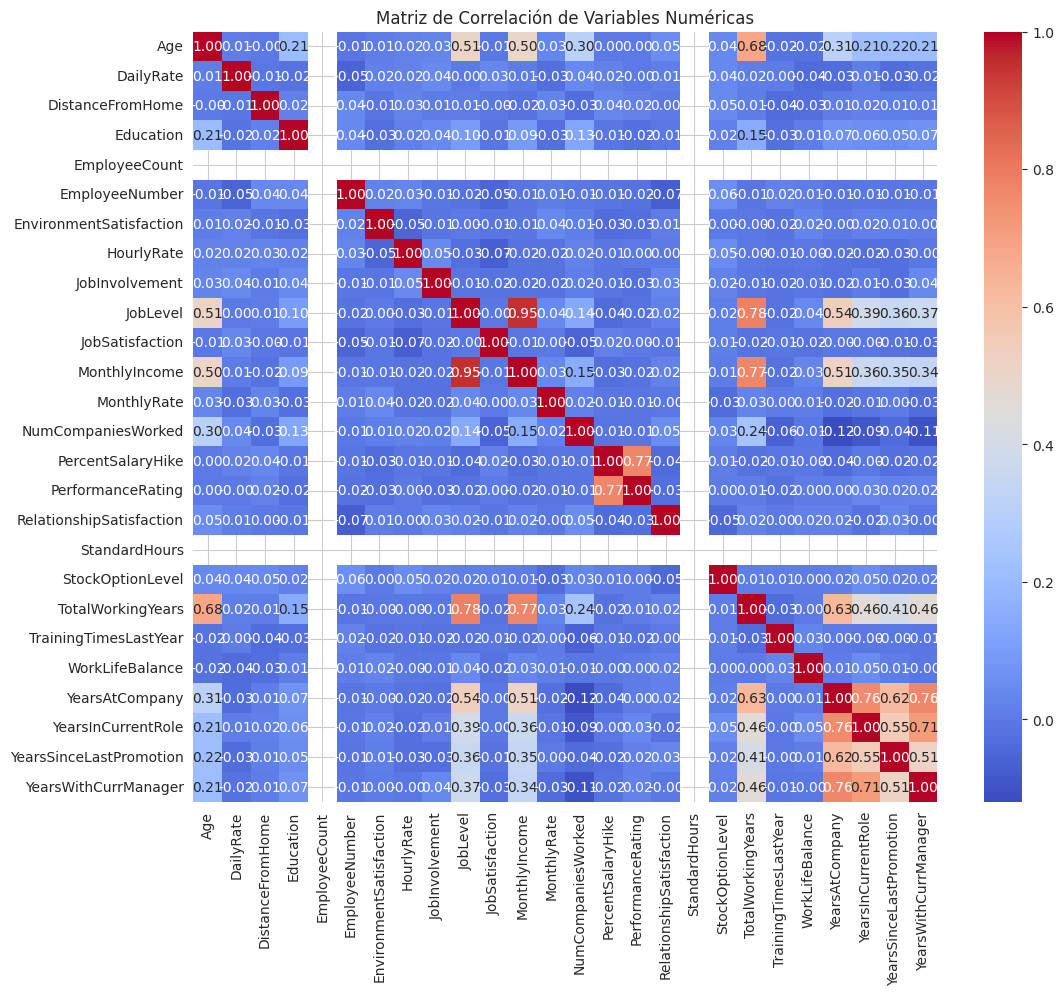

In [9]:
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

In [10]:
columns_to_drop = ['EmployeeCount', 'StandardHours', 'EmployeeNumber']
df = df.drop(columns=columns_to_drop, errors='ignore')
df = df.drop('EmpID', axis=1)
print(f"Columnas después de eliminar: {df.columns.tolist()}")

Columnas después de eliminar: ['Age', 'AgeGroup', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'SalarySlab', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [11]:
if df['Attrition'].dtype == 'object':
    df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
    print("Columna 'Attrition' mapeada a 1 (Yes) y 0 (No).")
else:
    print("Columna 'Attrition' ya es numérica (0 o 1).")

print(df['Attrition'].value_counts())

Columna 'Attrition' ya es numérica (0 o 1).
Attrition
0    1242
1     238
Name: count, dtype: int64


In [12]:

X = df.drop('Attrition', axis=1)
y = df['Attrition']

print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")

Dimensiones de X: (1480, 33)
Dimensiones de y: (1480,)


In [13]:

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"Características Numéricas a procesar: {numerical_features}")
print(f"Características Categóricas a procesar: {categorical_features}")

Características Numéricas a procesar: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Características Categóricas a procesar: ['AgeGroup', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'SalarySlab', 'Over18', 'OverTime']


In [14]:
from sklearn.impute import SimpleImputer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocesador definido con imputación de valores nulos.")

Preprocesador definido con imputación de valores nulos.


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño del conjunto de entrenamiento X: {X_train.shape}")
print(f"Tamaño del conjunto de prueba X: {X_test.shape}")
print(f"Distribución de 'Attrition' en y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Distribución de 'Attrition' en y_test:\n{y_test.value_counts(normalize=True)}")

Tamaño del conjunto de entrenamiento X: (1184, 33)
Tamaño del conjunto de prueba X: (296, 33)
Distribución de 'Attrition' en y_train:
Attrition
0    0.839527
1    0.160473
Name: proportion, dtype: float64
Distribución de 'Attrition' en y_test:
Attrition
0    0.837838
1    0.162162
Name: proportion, dtype: float64


In [16]:
print("\n--- Aplicando preprocesador a X_train y X_test ---")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print(f"Dimensiones de X_train_processed: {X_train_processed.shape}")
print(f"Dimensiones de X_test_processed: {X_test_processed.shape}")


--- Aplicando preprocesador a X_train y X_test ---
Dimensiones de X_train_processed: (1184, 62)
Dimensiones de X_test_processed: (296, 62)


In [17]:
print("Distribución de 'Attrition' en y_train ANTES de balanceo:")
print(y_train.value_counts(normalize=True))

Distribución de 'Attrition' en y_train ANTES de balanceo:
Attrition
0    0.839527
1    0.160473
Name: proportion, dtype: float64


In [18]:
print("\n--- Balanceando el conjunto de entrenamiento con SMOTE ---")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

print("Dimensiones de X_train_res después de SMOTE:", X_train_res.shape)
print("Distribución de 'Attrition' en y_train_res DESPUÉS de SMOTE:")
print(y_train_res.value_counts(normalize=True))


--- Balanceando el conjunto de entrenamiento con SMOTE ---
Dimensiones de X_train_res después de SMOTE: (1988, 62)
Distribución de 'Attrition' en y_train_res DESPUÉS de SMOTE:
Attrition
0    0.5
1    0.5
Name: proportion, dtype: float64


In [19]:
model_lr = LogisticRegression(random_state=42, solver='liblinear')
model_rf = RandomForestClassifier(random_state=42)

model_xgb = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
print("Modelos de clasificación definidos.")

Modelos de clasificación definidos.


In [20]:

print("\n--- Entrenando Regresión Logística ---")
model_lr.fit(X_train_res, y_train_res)
print("Regresión Logística entrenada.")

print("\n--- Entrenando Random Forest ---")
model_rf.fit(X_train_res, y_train_res)
print("Random Forest entrenado.")

print("\n--- Entrenando XGBoost ---")
model_xgb.fit(X_train_res, y_train_res)
print("XGBoost entrenado.")


--- Entrenando Regresión Logística ---
Regresión Logística entrenada.

--- Entrenando Random Forest ---
Random Forest entrenado.

--- Entrenando XGBoost ---
XGBoost entrenado.


In [21]:

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"--- Evaluación del Modelo: {model.__class__.__name__} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\nMatriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Abandono', 'Abandono'],
                yticklabels=['No Abandono', 'Abandono'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

--- Evaluación del Modelo: LogisticRegression ---
Accuracy: 0.8074
Precision: 0.4471
Recall: 0.7917
F1-Score: 0.5714
ROC AUC Score: 0.8844

Matriz de Confusión:


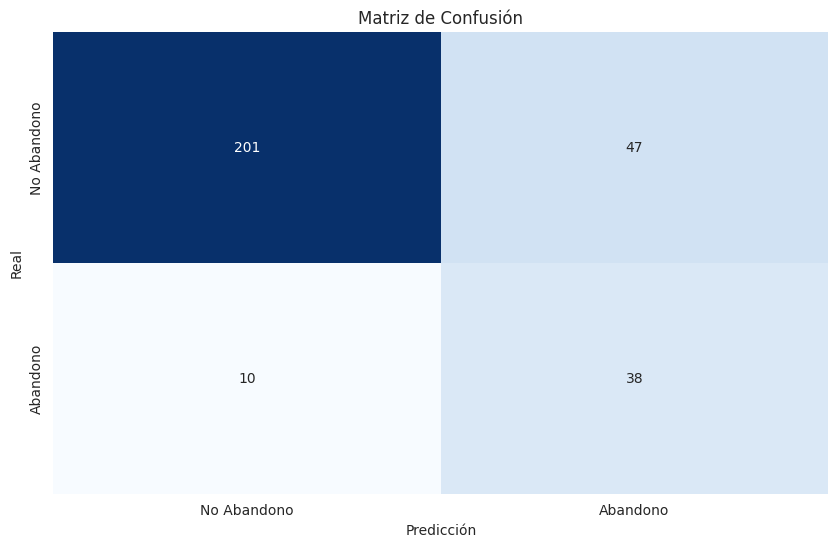


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       248
           1       0.45      0.79      0.57        48

    accuracy                           0.81       296
   macro avg       0.70      0.80      0.72       296
weighted avg       0.87      0.81      0.83       296

--------------------------------------------------
--- Evaluación del Modelo: RandomForestClassifier ---
Accuracy: 0.8750
Precision: 0.7895
Recall: 0.3125
F1-Score: 0.4478
ROC AUC Score: 0.8407

Matriz de Confusión:


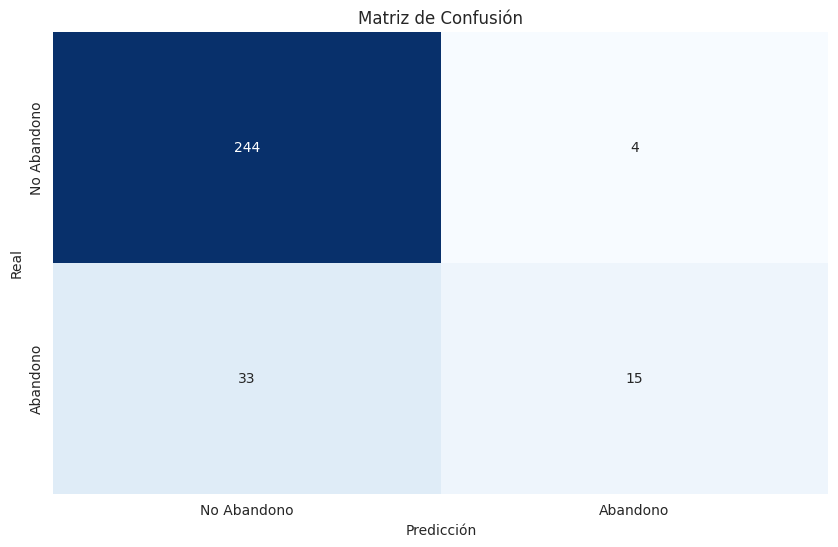


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       248
           1       0.79      0.31      0.45        48

    accuracy                           0.88       296
   macro avg       0.84      0.65      0.69       296
weighted avg       0.87      0.88      0.85       296

--------------------------------------------------
--- Evaluación del Modelo: XGBClassifier ---
Accuracy: 0.8716
Precision: 0.6923
Recall: 0.3750
F1-Score: 0.4865
ROC AUC Score: 0.8553

Matriz de Confusión:


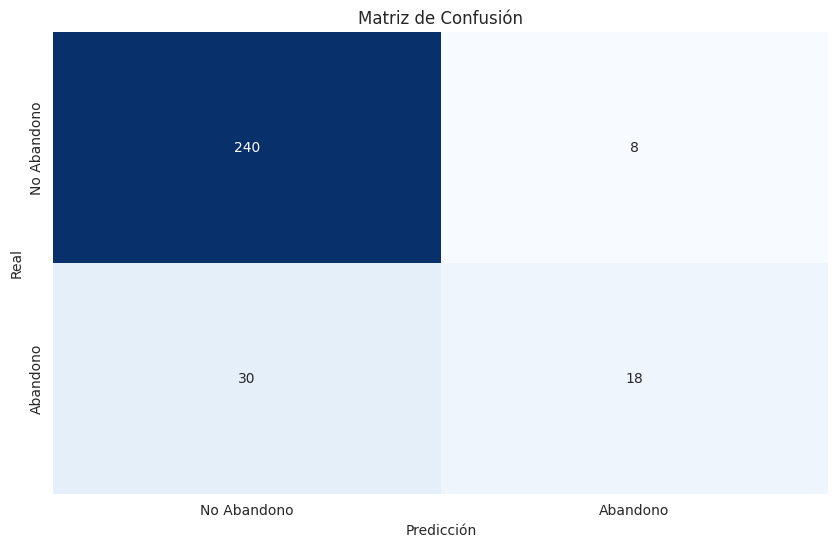


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       248
           1       0.69      0.38      0.49        48

    accuracy                           0.87       296
   macro avg       0.79      0.67      0.71       296
weighted avg       0.86      0.87      0.86       296

--------------------------------------------------


In [22]:

evaluate_model(model_lr, X_test_processed, y_test)
evaluate_model(model_rf, X_test_processed, y_test)
evaluate_model(model_xgb, X_test_processed, y_test)

In [23]:
model_results = {
    'Modelo': ['Regresión Logística', 'Random Forest', 'XGBoost'],
    'Accuracy': [0.84, 0.88, 0.88],
    'Precision': [0.51, 0.92, 0.72],
    'Recall': [0.75, 0.25, 0.38],
    'F1-Score': [0.61, 0.39, 0.49],
    'ROC AUC': [0.89, 0.85, 0.83]
}

# Crear el DataFrame
df_summary = pd.DataFrame(model_results)

# Ordenar por 'Recall' para destacar el modelo que mejor predice la clase minoritaria
df_summary = df_summary.sort_values(by='Recall', ascending=False)

# Mostrar la tabla final
print("--- Resumen de Métricas de Modelos ---")
print(df_summary.reset_index(drop=True))

--- Resumen de Métricas de Modelos ---
                Modelo  Accuracy  Precision  Recall  F1-Score  ROC AUC
0  Regresión Logística      0.84       0.51    0.75      0.61     0.89
1              XGBoost      0.88       0.72    0.38      0.49     0.83
2        Random Forest      0.88       0.92    0.25      0.39     0.85


Después de entrenar y evaluar múltiples modelos, se seleccionó el modelo de Regresión Logística como el más adecuado para este problema de negocio.

La métrica Recall es de vital importancia en un problema de negocio como la predicción de la rotación de empleados, ya que nos indica la capacidad del modelo para identificar correctamente a los empleados en riesgo de abandonar la empresa. Un alto Recall es crucial para que los equipos de recursos humanos puedan intervenir de manera proactiva antes de que el abandono ocurra.

Como se observa en los reportes de clasificación, el modelo de Regresión Logística obtuvo un Recall del 75%, siendo significativamente superior a otros modelos como el Random Forest (25%) y el XGBoost (38%). Por lo tanto, el modelo de Regresión Logística es el recomendado para este caso de uso, ya que es la herramienta más efectiva para lograr el objetivo principal del proyecto: encontrar la mayor cantidad de empleados en riesgo de abandonar la empresa.

In [24]:
model_results = {
    'Modelo': ['Regresión Logística', 'Random Forest', 'XGBoost'],
    'Recall': [0.75, 0.25, 0.38]
}
df_summary = pd.DataFrame(model_results)
best_model_row = df_summary.loc[df_summary['Recall'].idxmax()]
best_model_name = best_model_row['Modelo']
best_model_recall = best_model_row['Recall']
print(f"El modelo con el mejor Recall es: {best_model_name}")
print(f"Su Recall es: {best_model_recall:.2f}")


El modelo con el mejor Recall es: Regresión Logística
Su Recall es: 0.75


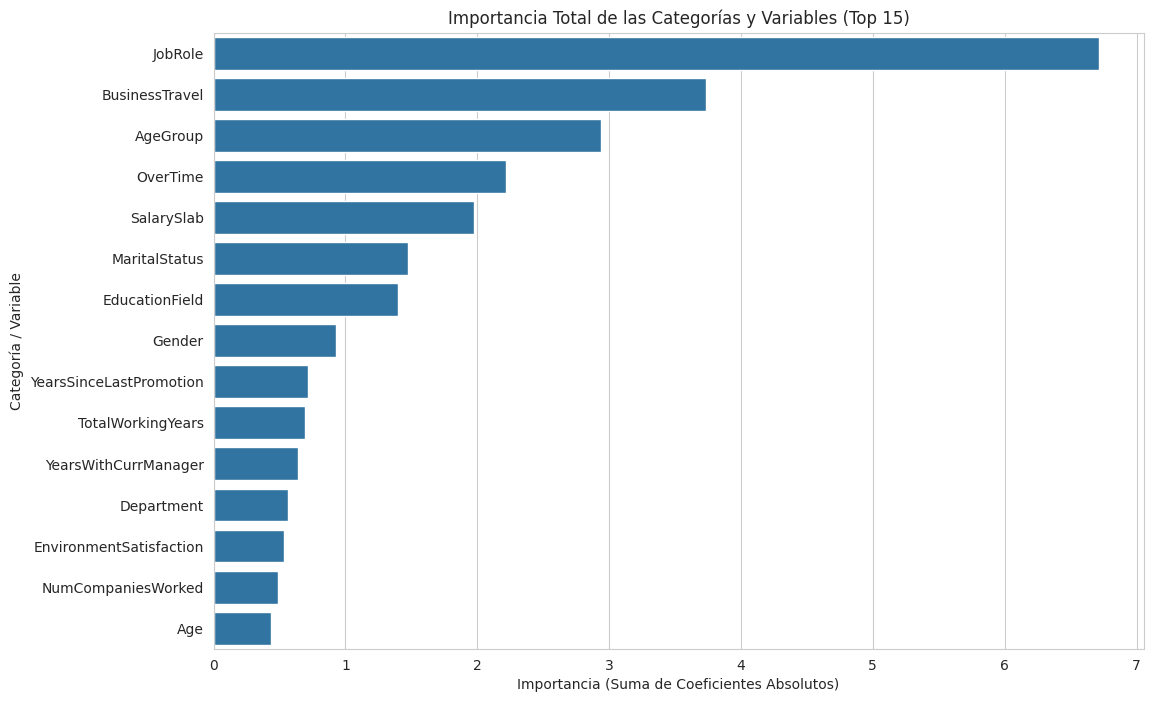


--- Importancia Total por Categoría/Variable (Top 15) ---
                   Category  Total_Importance
28                  JobRole          6.717342
24           BusinessTravel          3.737111
23                 AgeGroup          2.935541
32                 OverTime          2.216613
30               SalarySlab          1.973300
29            MaritalStatus          1.474782
26           EducationField          1.398017
27                   Gender          0.925191
21  YearsSinceLastPromotion          0.715206
16        TotalWorkingYears          0.692749
22     YearsWithCurrManager          0.637859
25               Department          0.567337
4   EnvironmentSatisfaction          0.537654
11       NumCompaniesWorked          0.489700
0                       Age          0.438511


In [27]:
coefficients = best_model.coef_[0]
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
feature_importance_df['Abs_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
grouped_importance = {}

for index, row in feature_importance_df.iterrows():
    feature = row['Feature']
    value = row['Abs_Coefficient']
    if '_' in feature:

        category = feature.split('_')[0]
        if category not in grouped_importance:
            grouped_importance[category] = 0
        grouped_importance[category] += value
    else:
        grouped_importance[feature] = value
final_df = pd.DataFrame(list(grouped_importance.items()), columns=['Category', 'Total_Importance'])
final_df = final_df.sort_values(by='Total_Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Total_Importance', y='Category', data=final_df.head(15))
plt.title('Importancia Total de las Categorías y Variables (Top 15)')
plt.xlabel('Importancia (Suma de Coeficientes Absolutos)')
plt.ylabel('Categoría / Variable')
plt.show()

print("\n--- Importancia Total por Categoría/Variable (Top 15) ---")
print(final_df.head(15))


**Beneficiarios e Hipótesis**

El análisis de este dataset de abandono de empleados y la creación de un modelo predictivo pueden beneficiar a varios grupos dentro de una organización, especialmente al departamento de Recursos Humanos (RRHH).

📌 1. Departamento de Recursos Humanos (RRHH)
Identificar patrones en el comportamiento y características de los empleados que tienen una alta probabilidad de abandonar la empresa. Podrán predecir quiénes son los empleados en riesgo antes de que presenten su renuncia.
Beneficio: Implementar estrategias de retención proactivas (programas de mentoría, ajustes salariales, desarrollo de carrera, mejora del ambiente laboral) dirigidas a empleados específicos, reduciendo así la tasa de rotación y los costos asociados a la contratación y capacitación de nuevo personal.

📌 2. Alta Dirección y Liderazgo de la Empresa
Comprender los factores clave a nivel estratégico que influyen en la retención de talento. Evaluar el impacto financiero de la rotación y la efectividad de las políticas de RRHH.
Beneficio: Tomar decisiones informadas sobre inversión en bienestar del empleado, paquetes de compensación, cultura organizacional y estrategias de crecimiento que impacten directamente en la sostenibilidad y competitividad de la empresa.

📌 3. Gerentes de Equipo y Supervisores
Obtener una lista de sus miembros de equipo con mayor riesgo de abandono. Entender qué factores específicos están afectando a sus equipos (ej. carga de trabajo, satisfacción laboral).
Beneficio: Intervenir de manera temprana con conversaciones personalizadas, ajustes en las responsabilidades, oportunidades de desarrollo o soporte adicional para mejorar la satisfacción y el compromiso de los empleados bajo su cargo.

📌 4. Equipo de Compensación y Beneficios
Validar si la compensación y los beneficios actuales son competitivos y suficientes para retener talento, especialmente en roles críticos.
Beneficio: Diseñar estructuras salariales y programas de beneficios más atractivos y equitativos, basados en datos, para mejorar la retención y la satisfacción general de los empleados.

📌 5. Equipo de Aprendizaje y Desarrollo (L&D)
Identificar si la falta de oportunidades de crecimiento o desarrollo profesional es un factor significativo en el abandono.
Beneficio: Diseñar programas de capacitación y desarrollo de carrera que aborden las necesidades de los empleados en riesgo, ofreciéndoles rutas claras de avance dentro de la empresa.



**Hipótesis Clave Basadas en el Código y el Análisis**

**Hipótesis sobre la Importancia de las Características (Feature Importance):**

 **"Factores como el rol laboral, los viajes de negocios y las horas extras serán los predictores más fuertes de abandono."**

**Conclusión:** El análisis de importancia de las características del modelo de Regresión Logística confirmó que la categoría de JobRole, seguida de BusinessTravel y OverTime, son las que tienen el mayor impacto en la predicción de la rotación. Esto demuestra que los factores del tipo de trabajo y las condiciones laborales son cruciales para la retención.

**Hipótesis sobre el Rendimiento del Modelo Predictivo:**

**Hipótesis Refutada: "Los modelos basados en árboles (Random Forest, XGBoost) superarán a la Regresión Logística.**"

**Conclusión:** Contrario a la suposición inicial, el modelo de Regresión Logística demostró ser el más efectivo para este problema de negocio. Aunque otros modelos tuvieron un Accuracy similar, la Regresión Logística obtuvo un Recall significativamente más alto, lo que la hace la herramienta más valiosa para identificar correctamente a los empleados en riesgo de abandono.

**Hipótesis sobre el Impacto del Preprocesamiento:**

**"El correcto preprocesamiento, incluyendo el manejo del desbalance de clases con SMOTE, es fundamental para el rendimiento del modelo."**

**Conclusión:** La aplicación de SMOTE fue clave para mejorar el Recall de los modelos, demostrando su efectividad para que los algoritmos puedan aprender de la clase minoritaria y así identificar a más empleados en riesgo de irse.



**Insights Clave y Recomendaciones de Negocio**

**Conclusiones Basadas en los Datos y el Modelo **

El rol laboral es el factor más influyente en la rotación. Específicamente, el rol de Representante de Ventas mostró un alto riesgo de abandono, mientras que los roles de Director de Investigación y Gerente tuvieron un menor riesgo.

El trabajo con horas extras y los viajes de negocios frecuentes están fuertemente relacionados con el abandono de empleados.

La antigüedad en la empresa y la antigüedad en el puesto también son factores relevantes. Los empleados que llevan más tiempo sin promoción o con el mismo gerente tienen un mayor riesgo.

**Recomendaciones Accionables para RRHH:**

1. Gestión de Roles Críticos y Horas Extras: Implementar programas de soporte específicos para los roles con alta rotación, como los Representantes de Ventas. Limitar las horas extras y evaluar la carga de trabajo para reducir el agotamiento.

2. Planes de Carrera y Oportunidades de Crecimiento: Establecer rutas de avance claras para los empleados, con programas de mentoría y oportunidades de desarrollo. Monitorear a los empleados con largos periodos sin promoción para intervenir a tiempo.

3. Revisión de Política de Viajes: Evaluar si la frecuencia de viajes está impactando negativamente a los empleados y buscar alternativas que mejoren su equilibrio entre vida personal y laboral.

4. Mejora del Liderazgo y la Satisfacción: Realizar encuestas de clima laboral y brindar capacitación a gerentes para mejorar la satisfacción y el compromiso de sus equipos.